### Camera caliberation code blocks
#### Ref
[OpenCV Camera Caliberation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration)
#### Notes
1. Determine interinsic and extrinsic parameters of a camera to undistort images.
2. *Intrinsic parameters* - 
    - Parameters specific to camera including focal lenghts (fx,fy), camera center (Cx,Cy), also called as camera matrix.
    - Its a camera property, so once calculated can be stored and used for future usage.
    - 3x3 matrix ![Interinsic parameters](https://opencv-python-tutroals.readthedocs.io/en/latest/_images/math/5e9d2db8b3561f68fa0688992fa45c13766a382c.png "Camera Matrix")
3. *Extrinsic parameters* - 
    - Combination of rotation and translation vectors to translate 3D world coordinates to camera coordinate system.
4. 
    - These distortions need to be corrected first by finding all these caliberation parameters. 
    - We generally do this by taking images having some **well-defined pattern** like checker-board, where we mark atleast 10 test points (*square corners etc.*) whose coordinates we know in *real-world space* as well as in the *2D image*.
    - We solve mathematical equations taking these 10 points and obtain distortion coefficints and interinsic/extrinsic parametrs.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Steps for finding caliberation matrices
1. For an image, detect chessBoardCorners by specifying what kind of pattern (8x8 grid OR 5x5 grid) we want to detect corners into, to `cv2.findChessboardCorners()` which returns corner points and retval (True if the pattern is obtained).
2. We should try the function on number of frames to get good pattern out of number of images.
3. `cv2.findCirclesGrid()` is used for detecting points out of circular pattern.
4. `cv2.cornerSubPix()` to increase accuracy of detected corner points.
5. `cv2.drawChessboardCorners()` to draw detected pattern on the image.
6. After having both the object-points (3D) and image-points(2D), we do caliberation using `cv2.caliberateCamera()` which retuens **Camera matrix, distortion coefficients and rotation-translation vectors**
7. Refine camera-matrix using `cv2.getOptimalNewCameraMatrix()`
8. Use `cv2.undistort()` to undistort image using refined camera-matrix and distortion-coefficients.
OR
9. find mapping b/w distorted and undistorted images using `cv2.initUndistortRectifyMap()` and apply the same using `cv2.remap()`
10. To estimate exactness of found parameters (interinsic, distortion, rotation and translation matrices), we reproject object-points to image points using these parameters and compare with actial image-points to get mean error.

### Epipolar Geometry
#### Ref
[OpenCV - Epipolar Geometry](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html)
#### Notes
1. When image is taken from single-camera, we *lose depth information*, due to 3D-2D conversion. 
2. But we can *estimate depth information using more than one cameras*. E.g. eyes act as *stereo vision* (2 cameras). 
3. Epipolar geometry is associated with *multi-view geometry* and involves concepts like *epipole, epipolar lines, and epipolar constraints*.
4. With single camera, we can't determine exact 3-D points`(X)` corresponding to a point`(x)` in the image plane, as *every point on the line joining camera-center`(O)` and object-point will project to the same point on the image plane*. But with a *second camera capturing same scene, that line`(OX)` projects to a line`(l')` on 2nd camera's image plane*. So with these 2 images, *we can determine the correct 3D/object-point by traingulation*.
5. **Epiline** 
    - Projection of line `OX` to 2nd camera's image plane `l'`. `l'` is the *epline* corresponding to the point `x` of 1st image. 
    - **Significance** To search corresponding point of `x` on the 2nd image, we need not search whole image, instead just the corresponding epiline. (also called *epipolar constraint*)
    - plane corresponding to 2 camera-centers and object-point is called **Epipolar plane**
6. **Epipole**
    - Projection of a camera-center on the image plane of another. Epipole is the point of intersection of line through camera center and image planes. 
    - Sometimes camera-center doesn't project onto another image plane, ie. one camera doesn't see the other.
    - *Epiline always passes through its epipole* i.e. epipole is the interention point of epilines. So we can find many epilines and their intersection point to get the epipole.
    - To determine epipoles and epilines, we need to find **Fundamental Matrix (F)** and **Essential matrix (E)**.
7. **Essential matrix**
    - Contains information on translation and rotation for determining location of 2nd camera w.r.t. 1st camera in the global coordinates.
8. **Fundamental matrix**
    - Contains same information as the *Essential Matrix* and also interinsics of both the cameras to map a point of an image to corresponding epiline in the 2nd image.
    - We need 8 corresponding/matching points to determine the fundamental matrix, using 8-point algorithm, although more number of matching points are preferred. RANSAC technique can be used to get robust set of matching points

$e^{i\pi} + 1 = 0$

### Camera Caliberation illustration
 - Ref : [Learnopencv - Camera Calibration using OpenCV](https://www.learnopencv.com/camera-calibration-using-opencv/)

In [7]:
#data/checker_board_imgs/
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, glob

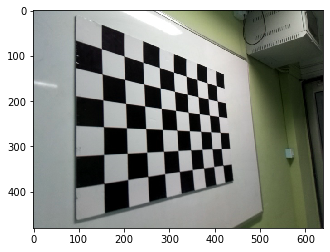

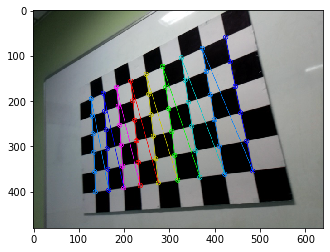

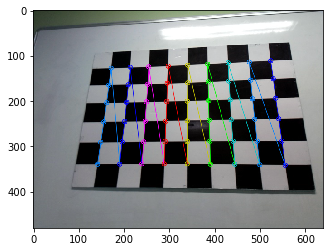

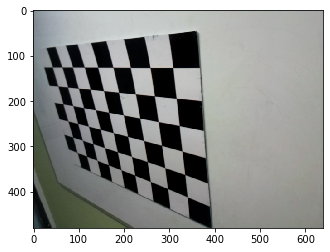

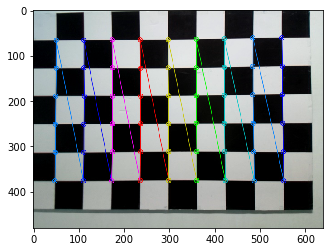

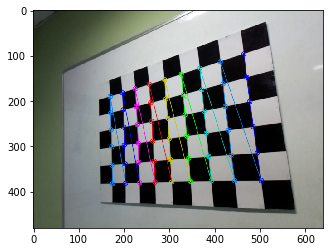

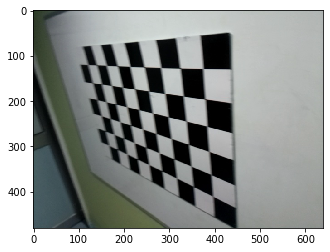

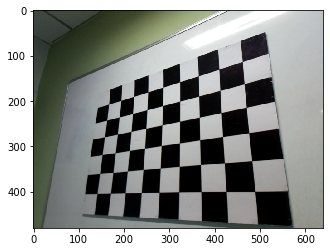

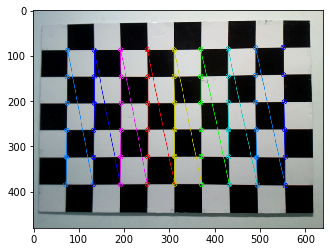

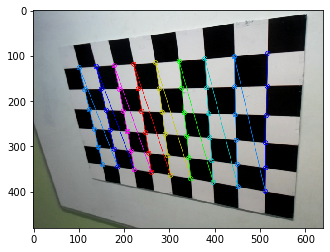

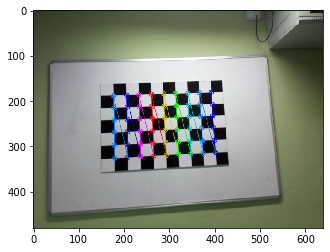

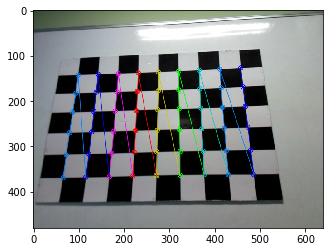

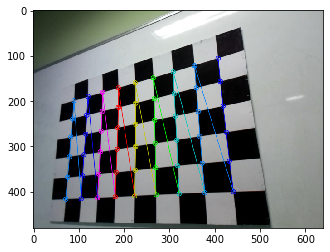

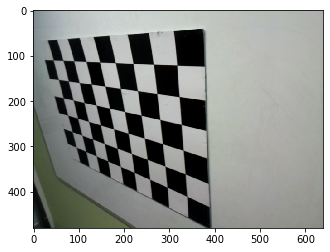

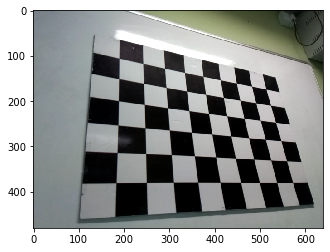

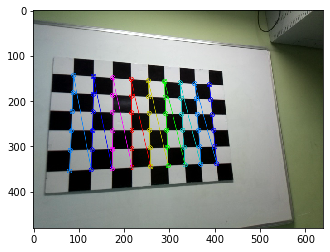

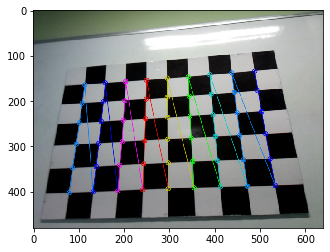

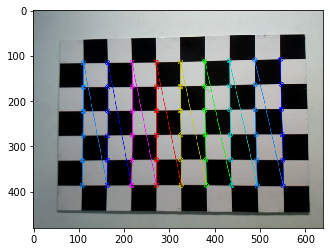

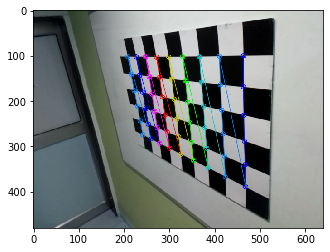

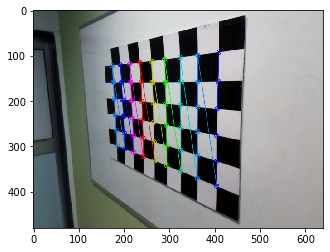

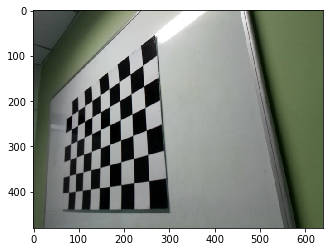

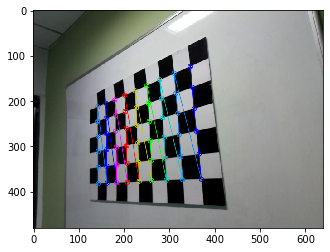

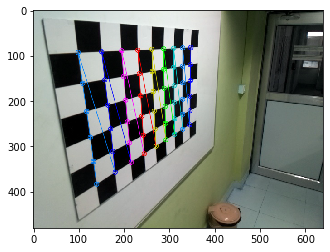

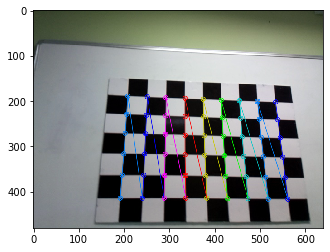

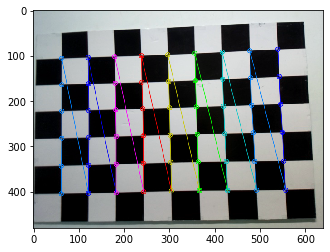

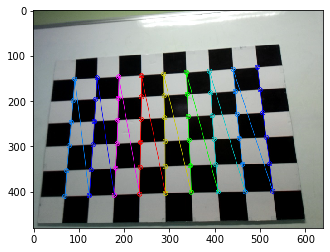

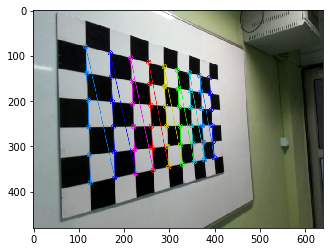

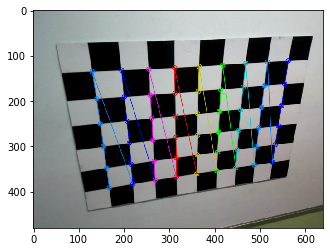

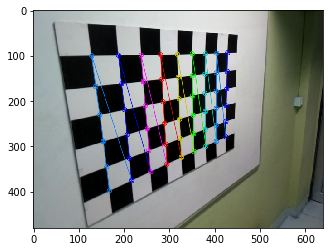

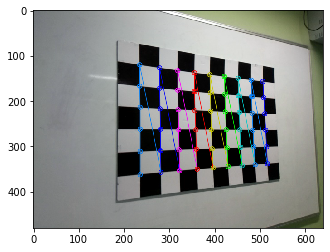

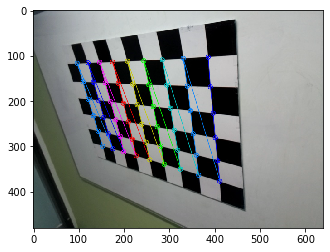

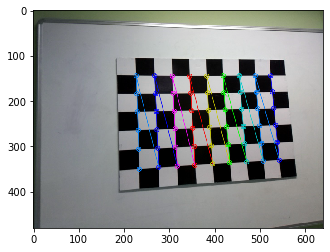

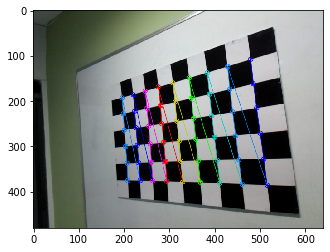

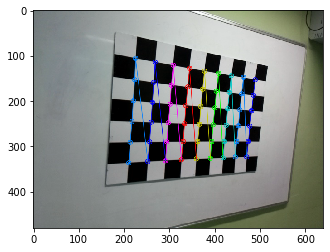

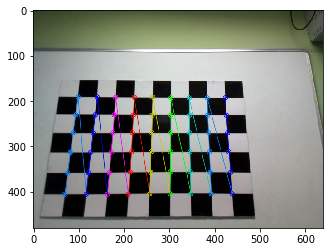

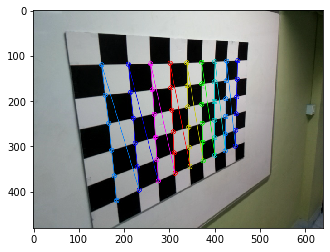

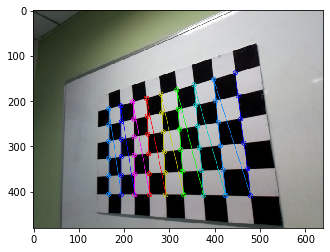

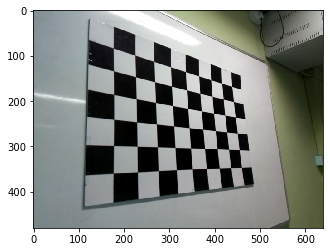

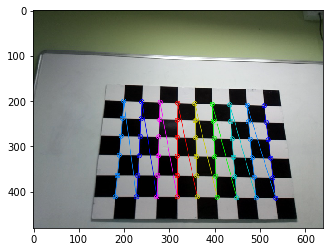

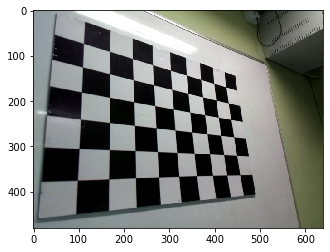

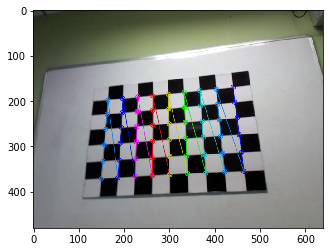

In [20]:
# Define checkerboard dimentions (number of intersecting corners)
CHECKERBOARD = (6,9)

# criteria for sub-pixel refinement of detected corners
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

# List of 3D world coordinate of each checkerboard image
objpoints = []
# List of 2D image pixel oordinate of each checkerboard image
imgpoints = []

# define 3D world coordinates for checkerboard points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Extracting path of individual image stored in a given directory
images = glob.glob('./data/checker_board_imgs/*.jpg')

for fname in images[:None]:
    img = cv2.imread(fname)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find checkerboard corners
    # ret will be True, if number of corners detected == size(CHECKERBOARD)
    ret, corners = cv2.findChessboardCorners(img_gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+
                                            cv2.CALIB_CB_NORMALIZE_IMAGE)
    # if ret==True, refine pixel coordinated upto subpix accuracy and display on the images
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(img_gray, corners, (11,11),(-1,-1), criteria)
        imgpoints.append(corners2)
        # draw image
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    plt.imshow(img, 'gray'); plt.show()

# Perform camera caliberation by passing 3D object points, 2D image pixel coords of detected corners
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)

In [21]:
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

Camera matrix : 

[[503.68450416   0.         313.67573031]
 [  0.         503.37968955 243.25588653]
 [  0.           0.           1.        ]]
dist : 

[[ 2.08347294e-01 -4.68636337e-01  4.51019151e-04 -1.93374517e-03
   2.37546112e-01]]
rvecs : 

[array([[0.28284897],
       [0.58780462],
       [1.31948586]]), array([[-0.19297665],
       [ 0.37179907],
       [ 1.55313082]]), array([[-9.09257806e-04],
       [ 3.66896302e-02],
       [ 1.56666808e+00]]), array([[0.3330713 ],
       [0.55841675],
       [1.39532886]]), array([[-1.46740509e-03],
       [ 4.76746201e-02],
       [ 1.56724465e+00]]), array([[0.61951983],
       [0.08486646],
       [1.49114073]]), array([[-0.15838455],
       [ 0.05212466],
       [ 1.52017064]]), array([[-0.21510674],
       [ 0.31910256],
       [ 1.53296637]]), array([[0.15172218],
       [0.57093047],
       [1.41375163]]), array([[-0.40374614],
       [-0.06016138],
       [ 1.53168658]]), array([[-0.21575773],
       [ 0.38055649],
       [ 1.50